In [1]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import copy
import torch.nn as nn
from tqdm import tqdm #for creating a progress bar during training loop

In [2]:
#Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The parity or symmetry of the wave functions is embedded in the model by defining the outputs as follows:
1. even symmetric and even w.r.t. x and y (such as $\psi_{00}, \hspace{2pt} \psi_{20}, \hspace{2pt} \psi_{02},...$) ---> 	$\mathcal{N}(\textbf{x},\textbf{y})+\mathcal{N}(-\textbf{x},\textbf{y})+\mathcal{N}(-\textbf{x},-\textbf{y})+\mathcal{N}(\textbf{x},-\textbf{y})$ 
2. odd w.r.t. x but even w.r.t. y (such as $\psi_{10},...$) --->  $\mathcal{N}(\textbf{x},\textbf{y})-\mathcal{N}(-\textbf{x},\textbf{y})-\mathcal{N}(-\textbf{x},-\textbf{y})+\mathcal{N}(\textbf{x},-\textbf{y})$ 	
3. odd w.r.t. y but even w.r.t. x (such as $\psi_{01},...$) --->  $\mathcal{N}(\textbf{x},\textbf{y})+\mathcal{N}(-\textbf{x},\textbf{y})-\mathcal{N}(-\textbf{x},-\textbf{y})-\mathcal{N}(\textbf{x},-\textbf{y})$ 
4. even symmetric but odd w.r.t. x and y (such as $\psi_{11},...$) --->  $\mathcal{N}(\textbf{x},\textbf{y})-\mathcal{N}(-\textbf{x},\textbf{y})+\mathcal{N}(-\textbf{x},-\textbf{y})-\mathcal{N}(\textbf{x},-\textbf{y})$

where $\mathcal{N}$, $\textbf{x}$, and $\textbf{y}$  represent the output of the network, x-coordinates and y-coordinates of the training points respectively.

The trial wave function is taken to be:\
$\Psi_{tr} = a + \textbf{B}(\textbf{x},\textbf{y})\odot\mathcal{N}(\textbf{x},\textbf{y})$\
where $a$ and $\textbf{B}$ are chosen to satisfy the boundary conditions and $\odot$ represents the element-wise product also known as Hadamard product or Schur product. The choice of $\textbf{B}$ also affects the convergence of the network. For the two-dimensional harmonic oscillator, one possible choice of $a$ and $\textbf{B}(\textbf{x},\lambda)$ is:\
$a =0,\hspace{8pt}\textbf{B}(\textbf{x},\textbf{y})=e^{-\lambda(\textbf{x}^2+\textbf{y}^2)}$ where $\lambda$ is a parameter adjusted for better results.
 
 



In [3]:
# Define the sin() activation function
class SinAct(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

class PINN2D(torch.nn.Module):
    
    """This network takes a x-point, y-point, and energy E as input and returns a wavefunction psi-point.
    E is automatically initialized and is passed through a linear network before being fed as 
    input along with the x-point."""
    
    def __init__(self, D_hid: int):
        super(PINN2D,self).__init__()  
        self.actF = SinAct()
        self.parity = 'gs'
        self.Lin_E   = torch.nn.Linear(1,1)
        self.Lin_1  = torch.nn.Linear(3, D_hid)
        #self.Lin_2  = torch.nn.Linear(D_hid+1, D_hid)
        self.Lin_out    = torch.nn.Linear(D_hid, 1)

    def forward(self,x_points: torch.Tensor,y_points: torch.Tensor, a:float):

        E_tr = self.Lin_E(torch.ones_like(x_points)) 
        E_tr = torch.abs(E_tr)

        l1_q1 = self.Lin_1(torch.cat((x_points,y_points,E_tr),1))
        l1_q2 = self.Lin_1(torch.cat((-1*x_points,y_points,E_tr),1))
        l1_q3 = self.Lin_1(torch.cat((-1*x_points,-1*y_points,E_tr),1))
        l1_q4 = self.Lin_1(torch.cat((x_points,-1*y_points,E_tr),1))

        sin_l1_q1 = self.actF(l1_q1)
        sin_l1_q2 = self.actF(l1_q2)
        sin_l1_q3 = self.actF(l1_q3)
        sin_l1_q4 = self.actF(l1_q4)

        if self.parity=='gs':
          out = self.Lin_out(sin_l1_q1 + sin_l1_q2 +sin_l1_q3 + sin_l1_q4)

        elif self.parity=='es_10':
          out = self.Lin_out(sin_l1_q1 - sin_l1_q2 - sin_l1_q3 + sin_l1_q4)
          
        elif self.parity=='es_11':
          out = self.Lin_out(sin_l1_q1 - sin_l1_q2 + sin_l1_q3 - sin_l1_q4)

        # Calculate wave function
        B = torch.exp(-0.5*(x_points**2+y_points**2))
        psi_tr  = a +  B*out

        return psi_tr, E_tr


In [4]:
def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
    df_value = output
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value


def get_points(x_domain: list, y_domain: list, dist_points_num: int , device = torch.device("cpu"), requires_grad=True):

    """This generates a 2D grid of points.
      dist_points_num (short for distinct points number) is the number of points in the interval [start,end].
      The generated grid consists of dist_points_num**2 number of points"""
    
    x_raw = torch.linspace(x_domain[0], x_domain[1], steps=dist_points_num, requires_grad=requires_grad)
    y_raw = torch.linspace(y_domain[0], y_domain[1], steps=dist_points_num, requires_grad=requires_grad)
    grids = torch.meshgrid(x_raw, y_raw, indexing='ij')
    x = grids[0].reshape(-1, 1).to(device)
    y = grids[1].reshape(-1, 1).to(device)
    return x, y

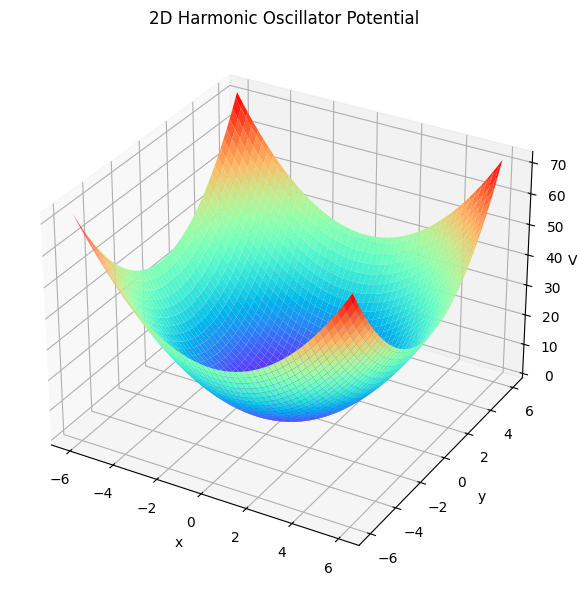

In [5]:
def Potential(x_points: torch.Tensor,y_points: torch.Tensor) -> torch.Tensor:
  omega = np.sqrt(2)
  m = 1
  V = 0.5 * m * omega **2 * (x_points**2 + y_points**2)
  return V


#Plot the potential
x_dom = [-6,6]
y_dom = x_dom
points_num = 100
xs, ys = get_points(x_dom, y_dom, points_num, requires_grad=False)
xs, ys = xs.reshape(points_num,points_num), ys.reshape(points_num,points_num) 
V = Potential(xs,ys)
V = V.reshape(points_num ,points_num )

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(xs, ys, V, cmap='rainbow', edgecolor='none')
ax.set_title('2D Harmonic Oscillator Potential')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('V')
ax.zaxis.labelpad=-1
plt.tight_layout()
plt.show()

The differential equation loss, which can be called Schrödinger equation loss for our case, defined by \
	$\mathcal{L}_{DE}= Mean\left(\left[\frac{1}{2} \left(\frac{\partial^2}{\partial x^2}+ \frac{\partial^2}{\partial y^2}\right) \Psi_{tr} + \left(\textbf{E}_{tr}- V\right)\Psi_{tr}\right]^2\right)$\
allows incorporating Schrödinger equation directly into training the model.

In [6]:
def SELoss(x_points: torch.Tensor, y_points: torch.Tensor, psi: torch.Tensor, E: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
    psi_ddx= df(psi,x_points,2)
    psi_ddy= df(psi,y_points,2)
    se = 0.5*(psi_ddx+psi_ddy) + (E-V)*psi
    l_se  = (se.pow(2)).mean(); 
    return l_se


The norm loss:\
$\mathcal{L}_{norm} = \left[\sqrt{\Psi_{tr}^T.\Psi_{tr}} - \frac{N}{(x_{max}-x_{min})(y_{max}-y_{min})}\right]^2 $\
 where $N$ is the number of co-ordinate pairs sampled from xy-pane, prevents the network from converging to a trivial solution. However, it does not normalize the wave function and manual normalizations is perfomed only after the wavefunctions are obtained.

In [7]:
def NormLoss(x_points: torch.Tensor, y_points: torch.Tensor, psi: torch.Tensor) -> torch.Tensor:
    points_num = len(x_points) # points_num = dist_points_num**2
    x_max = torch.max(x_points)
    x_min = torch.min(x_points)
    y_max = torch.max(y_points)
    y_min = torch.min(y_points)
    norm = torch.sqrt(torch.dot(psi[:, 0], psi[:, 0]))
    l_n = (points_num /((x_max-x_min)*(y_max-y_min)) - norm).pow(2)
    return l_n

In [8]:
def weights_init(m):
    """reinitializes weights"""
    if isinstance(m, nn.Linear) and m.weight.shape[0] != 1:
        torch.nn.init.xavier_uniform(m.weight.data)

To obtain the excited states, the following orthogonality loss is penalized:\
$\mathcal{L}_{ortho}^k=\left(\sum_{j=0}^{k-1}(\Psi_{tr})_j^T.(\Psi_{tr})_k\right)$\
The $k$ indicates that the loss is for the $(k+1)^{th}$ wave function (not necessarily the $k^{th}$ excited state ) and $k$ wave functions have already been discovered

In [9]:
def Train(neurons_num: int, epochs_num: int, x_domain: list, y_domain: list, dist_points_num: int, a=0.0, lr=1e-2) -> tuple[dict, tuple, float]:
    pinn = PINN2D(neurons_num)
    pinn.to(device)
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(pinn.parameters(), lr=lr, betas=betas)

    #Empy lists for storing loss and enrgy histories
    total_loss_history = []
    se_loss_history = []
    nontriv_loss_history = []
    ortho_loss_history = []
    E_history = []

    # Dictionary to store the best performing networks
    di = (None, 1e+20)
    model_storage = {}
    for j in range(4):
        model_storage[j] = di

    oc = 0 # Ortho-counter
  
    x_points, y_points = get_points(x_dom,y_dom,dist_points_num,requires_grad=True,device=device)

    t0 = time.time()
   
    with tqdm(total=epochs_num, desc="Training", ncols=150) as pbar:
        for epoch in range(epochs_num):
            psi, E = pinn(x_points,y_points,a)
            E_history.append(E[0].data.tolist()[0])
            V = Potential(x_points, y_points)
            se_loss = SELoss(x_points, y_points, psi, E, V)
            se_loss_history.append(se_loss)
            total_loss = se_loss
            norm_loss = NormLoss(x_points,y_points,psi)
            nontriv_loss_history.append(norm_loss)
            total_loss += norm_loss
            
            if epoch == 2e4: 
                pinn.apply(weights_init)
                pinn.parity = 'es_10'
                oc += 1
    
            if epoch == 4.5e4:
                pinn.parity = 'es_11'
                oc += 1

            # Ortho losses 
            if oc == 1:
                model_oc0 = model_storage[0][0]
                psi_oc0, E_oc0 = model_oc0(x_points,y_points,a)
                ortho_loss = torch.abs(torch.dot(psi_oc0[:, 0], psi[:, 0])) / 25
                ortho_loss_history.append(ortho_loss)
                total_loss += ortho_loss

            if oc == 2:
                model_oc0 = model_storage[0][0]
                model_oc1 = model_storage[1][0]
                psi_oc0, E_oc0 = model_oc0(x_points,y_points,a)
                psi_oc1, E_oc1 = model_oc1(x_points,y_points,a)
                ortho_loss = torch.abs(torch.dot(psi_oc0[:, 0]+psi_oc1[:, 0], psi[:, 0]))/25
                ortho_loss_history.append(ortho_loss)
                total_loss += ortho_loss

            # Optimization
            total_loss.backward(retain_graph=False) 
            optimizer.step()
            optimizer.zero_grad()
            total_loss_history.append(total_loss)

            if se_loss < model_storage[oc][1]:
                model_storage[oc] = (copy.deepcopy(pinn), se_loss)

            # Update additional info every 100 epochs for the progress bar
            if epoch % 100 == 0:
                oc_info = f"oc: {oc}"
                loss_info = f"loss: {total_loss.item():.4f}"
                E_info = f"E: {E[0].item():.4f}"
                pbar.set_postfix_str(f"{oc_info} | {loss_info}| {E_info}")
            # Update tqdm progress bar
            pbar.update(1)
        
    tf = time.time()
    runtime = tf - t0
    loss_histories = (total_loss_history, se_loss_history, nontriv_loss_history, ortho_loss_history, E_history)
    return model_storage, loss_histories, runtime

In [12]:
# train the model
neurons_num = 100
epochs_num = int(7.3e4)
x_domain = [-6,6]
y_domain= [-6,6]
dist_points_num =80
model_storage, loss_histories, runtime = Train(neurons_num, epochs_num, x_domain, y_domain, dist_points_num)

Training:  27%|█████████████████▌                                              | 19999/73000 [07:27<19:36, 45.04it/s, oc: 0 | loss: 0.0003| E: 1.4130]C:\Users\Asus\AppData\Local\Temp\ipykernel_16116\1974001475.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight.data)
Training: 100%|████████████████████████████████████████████████████████████████| 73000/73000 [32:03<00:00, 37.95it/s, oc: 2 | loss: 0.0024| E: 4.1937]


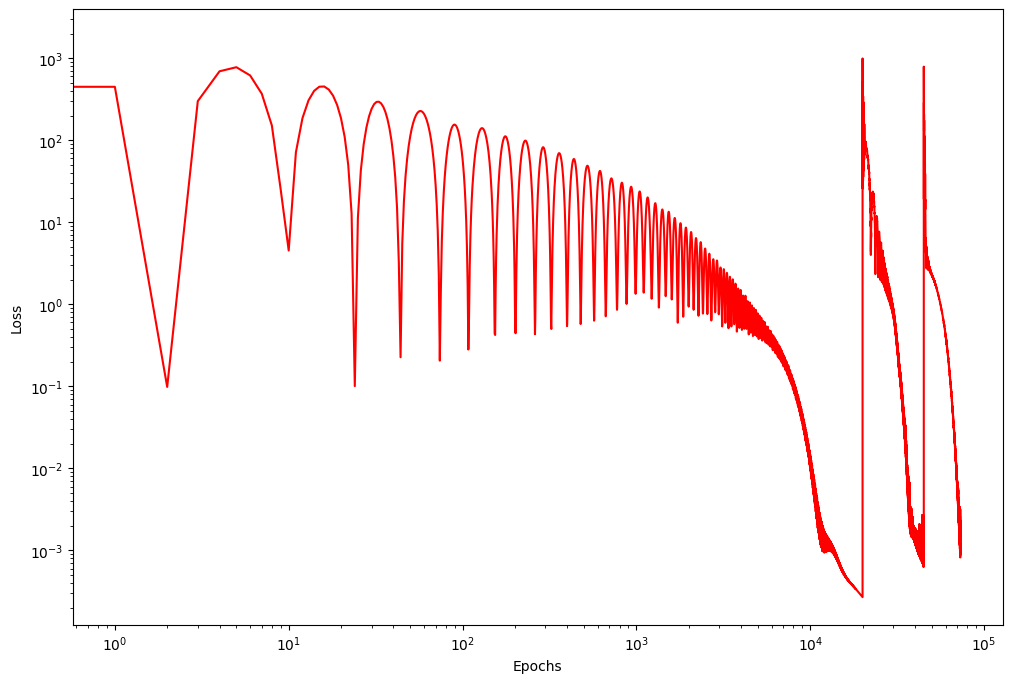

In [17]:
# plot the total loss
plt.figure(figsize = (12,8))
loss_hist =  [tensor.cpu().detach().numpy() for tensor in loss_histories[0]]
plt.loglog(loss_hist,color='red')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

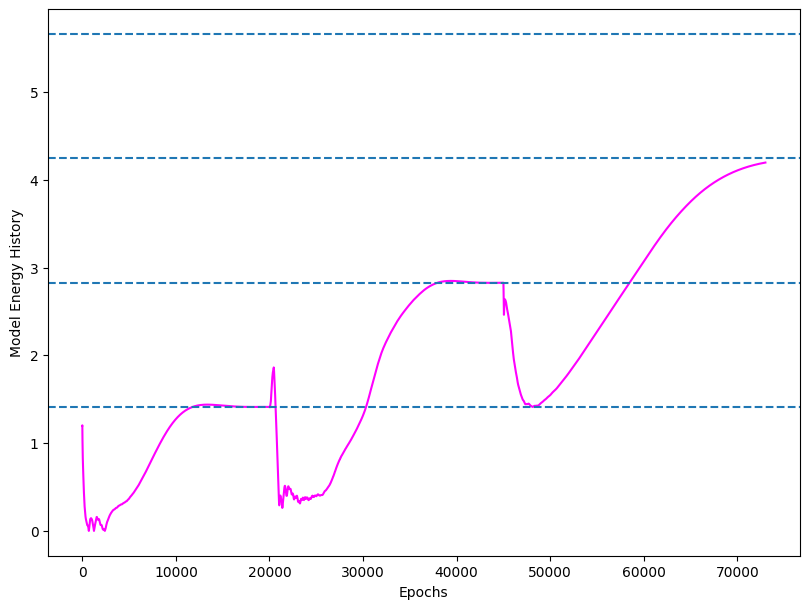

In [14]:
# plot the energy history
plt.figure(figsize = (8,6))
plt.plot(loss_histories[-1],color='magenta')
plt.tight_layout()
plt.ylabel('Model Energy History')
plt.xlabel('Epochs')
plt.axhline(y=1.4142,linestyle='--')
plt.axhline(y=2.8284,linestyle='--')
plt.axhline(y=4.2426,linestyle='--')
plt.axhline(y=5.6568,linestyle='--')

Energy:  1.413086175918579
Energy:  2.8260507583618164
Energy:  4.194786548614502


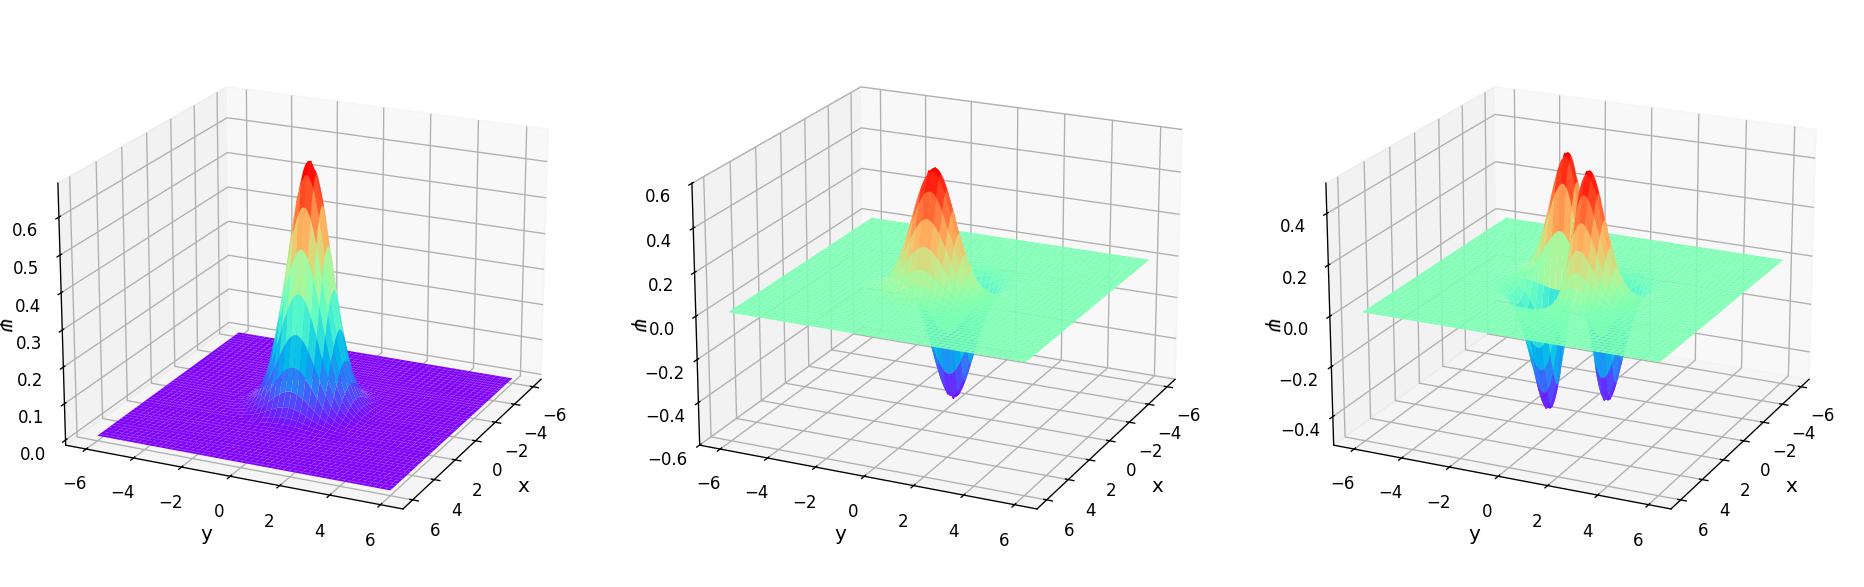

In [16]:
#Plot the wave functions

dist_points_num = 200
x, y = get_points(x_domain, y_domain, dist_points_num, requires_grad=False)
a = 0.0

# Reshape
xs, ys = x.reshape(dist_points_num, dist_points_num).data.numpy(), y.reshape(dist_points_num, dist_points_num).data.numpy()

# Create a figure and subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=120, subplot_kw={'projection': '3d'})

for j in range(3):
    model = model_storage[j][0].cpu()
    psi, E = model(x, y, a)
    print('Energy: ', E[0].item())
    psi = psi.data.numpy()

    # Normalize
    prod = np.dot(psi[:, 0], psi[:, 0])
    A = (dist_points_num**2 / 144) * (1 / prod)
    psi = psi * np.sqrt(A)
    psi = psi.reshape(dist_points_num, dist_points_num)

    # Plot on the corresponding subplot
    ax = axes[j]
    surf = ax.plot_surface(xs, ys, -psi, cmap='rainbow')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_zlabel(r'$\psi$', fontsize=12, rotation=50)
    ax.zaxis.labelpad = -1.11
    ax.view_init(elev=20, azim=25)

plt.tight_layout()
plt.show()


